# 병합된 데이터로 LSTM 훈련

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os

import pickle
import pandas as pd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
import joblib

In [3]:
# 모델을 구축하기 위한 keras 관련 함수
from tensorflow.keras.models import *
from tensorflow.keras.layers import Lambda, RepeatVector
from tensorflow.keras.layers import Input, multiply
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import regularizers
import keras.backend as K
from keras.callbacks import EarlyStopping

## LSTM모델 정의

In [4]:
def lstm_model(batch_size, time_step, feature_num):
        """LSTM 모델 정의"""
        inputs = Input(shape=(time_step, feature_num))
        x = LSTM(6, activation='tanh',
        stateful=False,
        return_sequences=True,
        kernel_initializer='he_normal')(inputs)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(10, activation='linear', kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l1(0.))(x)
        output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)

        model = Model(inputs=[inputs], outputs=output)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        return model,early_stopping

## LSTM모델에 입력할 형태로 데이터 변환(window_size=24)

In [5]:
def data_transform(name,time_steps):
    data=pd.read_csv("../Merged_Data/{:s}.csv".format(name))
    
    print("column =",data.columns)
    
    if name.split("_")[-1]=='x':
        sequences=[]
        for i in range(len(data) - time_steps + 1):
            sequence = data[i:i+time_steps]
            sequences.append(sequence)
        return np.array(sequences)
    
    return np.array(data[23:])

In [6]:
train_x=data_transform('train_x',24)
train_y=data_transform('train_y',24)
test_x=data_transform('test_x',24)
test_y=data_transform('test_y',24)
valid_x=data_transform('valid_x',24)
valid_y=data_transform('valid_y',24)

column = Index(['in_co2', 'in_humi', 'in_pm10', 'in_temp', 'in_voc'], dtype='object')
column = Index(['Y_pm10'], dtype='object')
column = Index(['in_co2', 'in_humi', 'in_pm10', 'in_temp', 'in_voc'], dtype='object')
column = Index(['Y_pm10'], dtype='object')
column = Index(['in_co2', 'in_humi', 'in_pm10', 'in_temp', 'in_voc'], dtype='object')
column = Index(['Y_pm10'], dtype='object')


In [8]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)

(55204, 24, 5)
(55204, 1)
(3045, 24, 5)


## 하이퍼 파라미터 정의

In [9]:
batch_size = 1
time_steps = 24
feature_num = 5

In [ ]:
model,early_stopping=lstm_model(batch_size, time_steps, feature_num)
model.compile(loss='mean_squared_error', optimizer='adam')

## 모델 훈련(epoch=100)

In [10]:
history = model.fit(train_x, train_y,
                    validation_data=(valid_x, valid_y),
                    batch_size=batch_size, epochs=100)

Epoch 1/100
55204/55204 [==============================] - 141s 3ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 2/100
55204/55204 [==============================] - 140s 3ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 3/100
55204/55204 [==============================] - 141s 3ms/step - loss: 0.0074 - val_loss: 0.0052
Epoch 4/100
55204/55204 [==============================] - 141s 3ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 5/100
55204/55204 [==============================] - 143s 3ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 6/100
55204/55204 [==============================] - 150s 3ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 7/100
55204/55204 [==============================] - 143s 3ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 8/100
55204/55204 [==============================] - 140s 3ms/step - loss: 0.0073 - val_loss: 0.0054
Epoch 9/100
55204/55204 [==============================] - 141s 3ms/step - loss: 0.0073 - val_loss: 0.0054
Epoch 10/100
55204/55204 [===========

## 모델 저장, test set 예측 결과 확인

In [11]:
model.save('./Saved_Model/LSTM(epoch=100).pt')

INFO:tensorflow:Assets written to: ./Saved_Model/LSTM(epoch=100).pt\assets


INFO:tensorflow:Assets written to: ./Saved_Model/LSTM(epoch=100).pt\assets


In [10]:
from tensorflow.python.keras.models import load_model
LSTM_model=load_model('./Saved_Model/LSTM(epoch=100).pt')

train_predict = LSTM_model.predict(train_x, batch_size)
valid_predict = LSTM_model.predict(valid_x, batch_size)
test_predict = LSTM_model.predict(test_x, batch_size)

## sclaer를 불러와서 inverse transform 적용

In [11]:
import joblib
scaler=joblib.load('../Merged_Data/Scaler/Y_pm10.pkl')

inv_test_y = scaler.inverse_transform(test_y)
inv_test_predict = scaler.inverse_transform(test_predict)

## 성능 평가 : SMAPE

In [ ]:
def Symmetric_mean_absolute_percentage_error(actual, predicted):
    
    total=len(actual)
    numerator=np.abs(actual-predicted)
    denominator=np.abs(actual)+np.abs(predicted)
    SMAPE=(100/total)*np.sum(numerator/denominator)
    
    return SMAPE

In [14]:
test_smape = Symmetric_mean_absolute_percentage_error(inv_test_y, inv_test_predict)

In [15]:
print("Test SMAPE: %.2f" % test_smape)

Train SMAPE: 11.82
Valid SMAPE: 18.50
Test SMAPE: 9.02


## 결과 시각화

In [16]:
def vizualization_self(train_term,name,test_y,pred_y):
    plt.figure(figsize=(32, 16))
    
    plt.plot(np.arange(train_term), test_y[:train_term], color='red', ls='-', lw=3, label='Raw Data')
    plt.plot(np.arange(train_term), pred_y[:train_term], color='blue', ls='--', lw=3, label='Raw Data')
    
    plt.xlabel('[Time]', fontsize=25, fontweight='bold')
    plt.ylabel('[PM10]', fontsize=25, fontweight='bold')
    plt.title('Prediction Visualization({:s})'.format(name),fontsize=30, weight='bold')
    plt.xticks( fontsize=15, fontweight='bold')
    plt.yticks( fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.legend()
    return

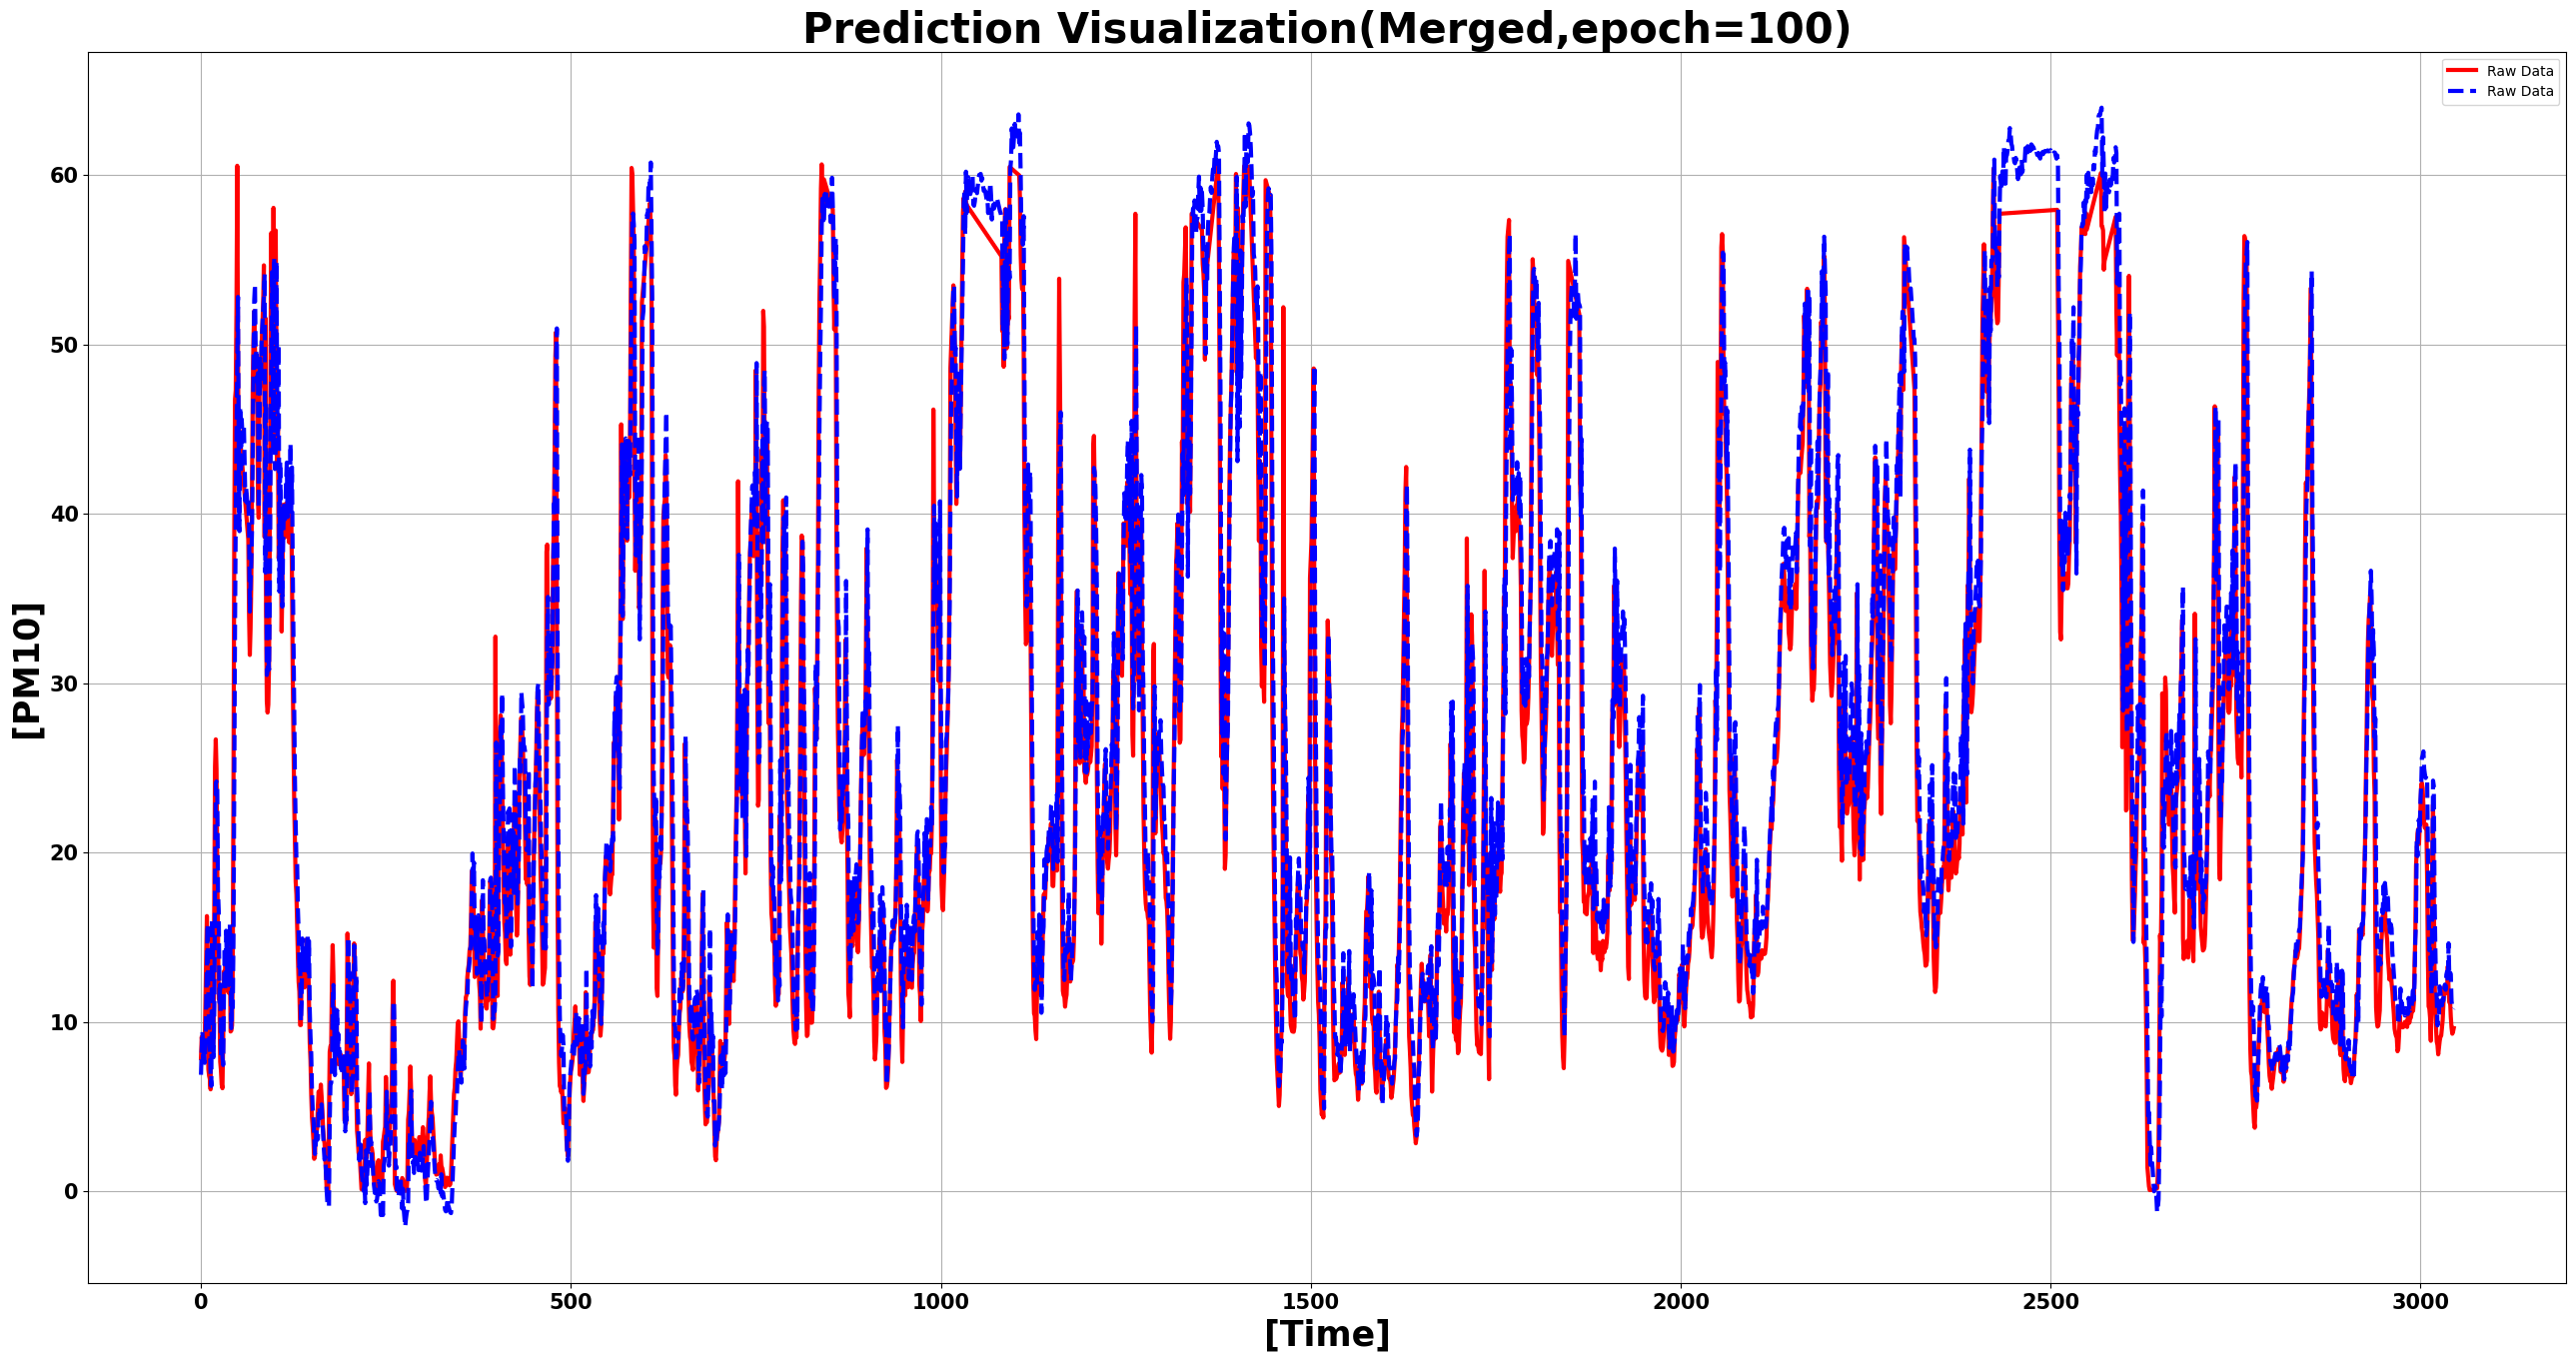

In [17]:
vizualization_self(len(inv_test_y),'Merged,epoch=100',inv_test_y,inv_test_predict)

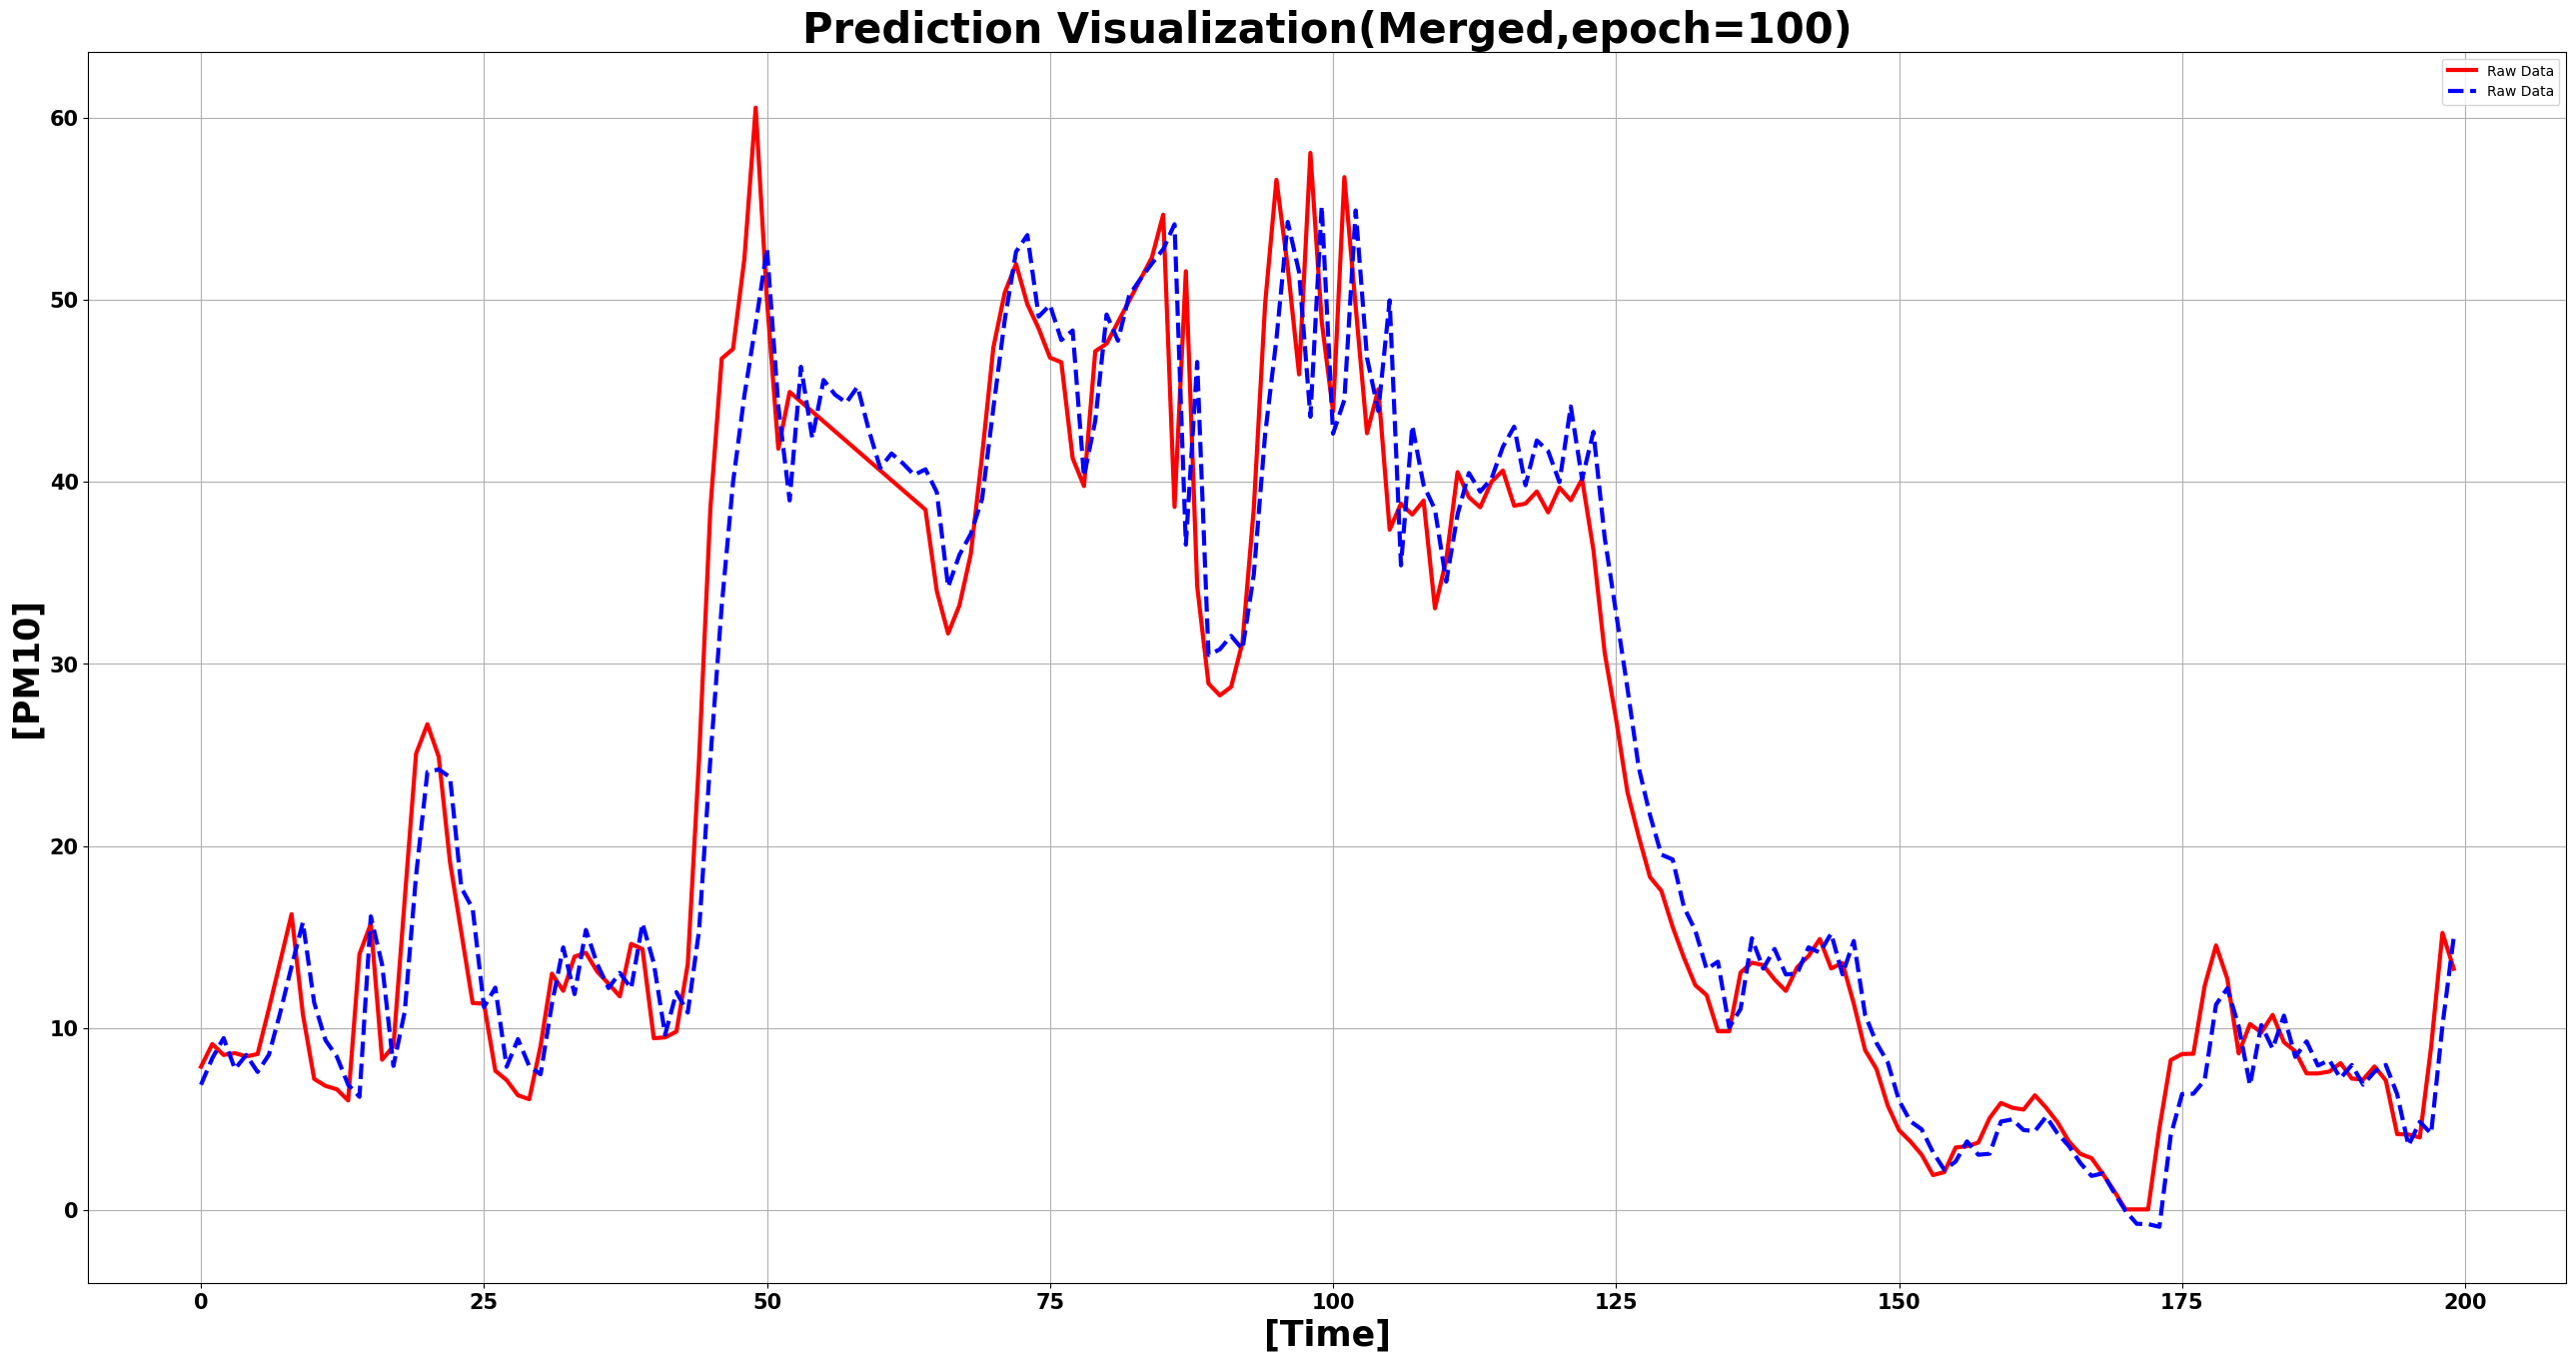

In [20]:
vizualization_self(200,'Merged,epoch=100',inv_test_y,inv_test_predict)